In [ ]:
# Cài đặt thư viện timm (vì Colab chưa có sẵn)
!pip install timm -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import cv2
import numpy as np
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt

# --- CẤU HÌNH (SOTA V5) ---
MODEL_PATH = "/content/drive/MyDrive/best_v2.pth"  # Tên file bạn vừa upload
IMG_SIZE = 300
BEST_THRESHOLD = 0.43       # Ngưỡng tối ưu tìm được ở V5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. HÀM LOAD MODEL ---
def load_trained_model():
    print(f"Đang tải model {MODEL_PATH} lên {DEVICE}...")
    try:
        # Khởi tạo kiến trúc giống hệt lúc train V2 (num_classes=2)
        model = timm.create_model("tf_efficientnet_b3.ns_jft_in1k", pretrained=False, num_classes=2)

        # Load weights (map_location để chạy được cả khi không có GPU)
        checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

        # Xử lý checkpoint
        if 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        else:
            model.load_state_dict(checkpoint)

        model.to(DEVICE)
        model.eval()
        print("Model đã sẵn sàng!")
        return model
    except FileNotFoundError:
        print(f"Không tìm thấy file '{MODEL_PATH}'. Hãy kéo thả file model vào thư mục bên trái!")
        return None

# --- 2. HÀM XỬ LÝ ẢNH & TTA ---
def predict_image(model, image_bytes):
    # Đọc ảnh từ bytes (do Colab upload lên)
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
    image = np.array(image) # Chuyển sang numpy (H, W, C)

    # Định nghĩa Transform cơ bản
    base_aug = A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    # Định nghĩa TTA Transforms (5 views: Gốc, Lật, Xoay, Sáng)
    tta_transforms = [
        base_aug, # View 1: Gốc
        A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.HorizontalFlip(p=1), A.Normalize(), ToTensorV2()]),
        A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.VerticalFlip(p=1), A.Normalize(), ToTensorV2()]),
        A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.Rotate(limit=15, p=1), A.Normalize(), ToTensorV2()]),
        A.Compose([A.Resize(IMG_SIZE, IMG_SIZE), A.ColorJitter(brightness=0.2, p=1), A.Normalize(), ToTensorV2()]),
    ]

    # Chạy dự đoán 5 lần
    probs_list = []
    with torch.no_grad():
        for t in tta_transforms:
            # Augment ảnh
            aug_img = t(image=image)['image'].unsqueeze(0).to(DEVICE)

            # Forward pass
            outputs = model(aug_img)

            # Softmax lấy xác suất lớp Malignant (cột 1)
            prob = torch.softmax(outputs, dim=1)[:, 1].item()
            probs_list.append(prob)

    # Lấy trung bình cộng (Logic của V5)
    final_prob = np.mean(probs_list)
    return image, final_prob

# --- 3. GIAO DIỆN DEMO ---
def run_demo():
    model = load_trained_model()
    if model is None: return
    uploaded = files.upload()

    for fn in uploaded.keys():
        print(f"\nĐang phân tích ảnh: {fn} ...")

        # Dự đoán
        original_img, prob = predict_image(model, uploaded[fn])

        # Ra quyết định
        is_malignant = prob >= BEST_THRESHOLD
        label = "ÁC TÍNH (Malignant)" if is_malignant else "LÀNH TÍNH (Benign)"
        color = 'red' if is_malignant else 'green'

        # Hiển thị kết quả
        plt.figure(figsize=(6, 6))
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(f"{label}\nXác suất: {prob:.4f} (threshold: {BEST_THRESHOLD})",
                  color=color, fontsize=14, fontweight='bold')
        plt.show()

Đang tải model /content/drive/MyDrive/best_v2.pth lên cuda...
Model đã sẵn sàng!


Saving Screenshot from 2025-12-12 18-55-59.png to Screenshot from 2025-12-12 18-55-59.png

Đang phân tích ảnh: Screenshot from 2025-12-12 18-55-59.png ...


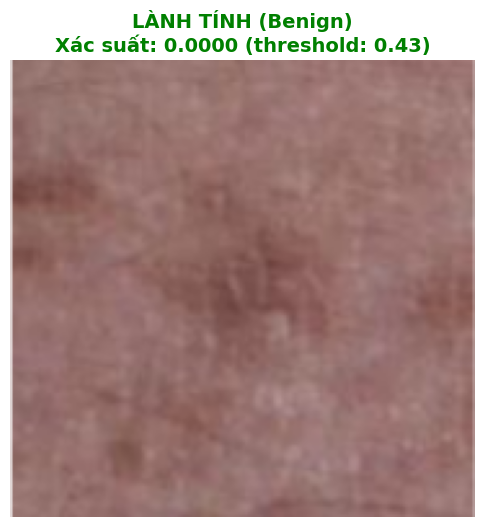

In [ ]:
# --- CHẠY ---5
run_demo()